# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда
нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое,
чтобы можно было обучить хорошую стратегию методами TD-обучения или другими
методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том
числе и достаточно техническое, так что для решения придётся немножко
попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук
на вашем github (или публичный, или с доступом для snikolenko); ссылку
обязательно нужно прислать в виде сданного домашнего задания на портале
Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда,
категорически приветствуются.

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая
реализована в OpenAI Gym:

* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для
валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит
21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко,
если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
    * hit — взять ещё одну карту;
    * stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока
сумма карт в его руке меньше 17;
*  после этого игрок выигрывает, если дилер либо превышает 21, либо получает
сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется
ничья (ставка возвращается);
*  в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5
(полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [1]:
import gym
from collections import defaultdict
import tqdm
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [3]:
observation = env.reset()
print(f'observation: {observation}')
done = False
while not done:
    if observation[0] < 19:
        observation, reward, done, _ = env.step(1)
        print(f"observation: {observation}, reward: {reward}, done: {done}")
    else:
        observation, reward, done, _ = env.step(0)
        print(f"observation: {observation}, reward: {reward}, done: {done}")
    

observation: (16, 1, False)
observation: (17, 1, False), reward: 0.0, done: False
observation: (26, 1, False), reward: -1.0, done: True


In [4]:
def run_episode(env, pi, eps=.01):
    observation = env.reset()
    s_id = states_to_idx[observation]
    # states, rewards, actions = [], [], []
    done = False
    
    while not done:
        # epsilon policy
        action = pi[s_id] if np.random.rand() > eps else env.action_space.sample()
        # states.append(observation)
        # actions.append(action)
        observation, reward, done, _ = env.step(action)
        s_id = states_to_idx[observation]
        # rewards.append(reward)

    return reward

### 1.1 Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [5]:
# в дискретном пространстве состояний можно записать стратегию 
# как словарь состоягие -> действие

states_list = list(
    itertools.product(
        range(2, 33), # the players current sum, 32 для Q learning !!!!!!!!
        range(1, 11), # the dealer's one showing card (1-10 where 1 is ace),
        (True, False) # the player holds a usable ace
    )
)

In [6]:
states_to_idx = {state: i for i, state in enumerate(states_list)}

In [7]:
# если сумма меньше 19, то hit
pi = {
    states_to_idx[state]: int(state[0] < 19)
    for state in states_list
}

In [8]:
def avg_reward(env, pi, epochs=100000):
    sum_reward = 0
    cnt = 0
    for _ in tqdm.tqdm(range(epochs)):
        cnt += 1
        reward = run_episode(env, pi, eps=0.)
        sum_reward += reward
    return sum_reward / cnt

In [9]:
avg_reward(env, pi)

100%|██████████| 100000/100000 [00:06<00:00, 15303.35it/s]


-0.17979

### 1.2 Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [10]:
def get_random_Q(env):
#     # инициализируем случайным образом
#     Q = {
#         state: np.zeros(env.action_space.n) #np.random.random(env.action_space.n)
#         for state in states_list
#     }
#     for state in states_list:
#         if state[0] == 21:
#             Q[state] = np.zeros(env.action_space.n)   
#    return defaultdict(lambda: np.zeros(env.action_space.n))
    return np.zeros((len(states_list), env.action_space.n))

def compute_policy_by_Q(env, Q, gamma=1.0):
#     d = {key: np.argmax(value) for key, value in Q.items()}
#     return defaultdict(int, d)
    return np.argmax(Q, axis=1)

In [11]:
def Q_learning_episode(env, pi, Q, alpha=0.1, epsilon=0.1, gamma=0.9):
    done = False
    observation = env.reset()
    while not done:
        s_id = states_to_idx[observation]
        a = pi[s_id] if np.random.rand() > epsilon else env.action_space.sample()
        observation_prime, reward, done, _ = env.step(a)
        s_id_prime = states_to_idx[observation_prime]
        # print(observation_prime, reward, done)
        Q[s_id][a] += alpha * (
            reward + gamma * np.max(Q[s_id_prime]) - Q[s_id][a]
        )
        observation = observation_prime
    return Q

In [12]:
env.close()
env = gym.make('Blackjack-v0', natural=True)

def Q_learning(env, alpha=0.005, epsilon=0.05, gamma=0.1, epochs=500000, track_history=False):
    # Q_hist_Qlearn = [ ]
    pi_hist = []

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for n in tqdm.tqdm(range(epochs)):
        Q = Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi = compute_policy_by_Q(env, Q)
        # Q_hist_Qlearn.append(copy.deepcopy(Q))
        if n % 25000 == 0 and track_history:
            pi_hist.append(pi)
            
    return pi, pi_hist

In [13]:
pi, pi_hist = Q_learning(env, track_history=True)

100%|██████████| 500000/500000 [00:46<00:00, 10715.49it/s]


In [14]:
avg_reward(env, pi)

100%|██████████| 100000/100000 [00:07<00:00, 13749.32it/s]


-0.02656

### 1.3 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [15]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

100%|██████████| 200000/200000 [00:14<00:00, 14173.34it/s]


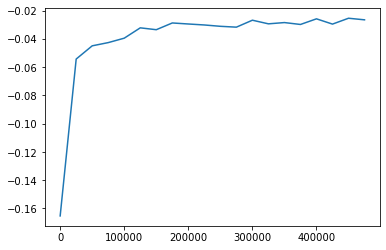

In [16]:
plt.plot(list(range(0, 500000, 25000)), avg_reward_hist)

### 1.3 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [19]:
def tuning_params(
    env,
    alpha_values,
    epsilon_values,
    gamma_values,
    train_epochs=500000,
    eval_epochs=200000
):
    best_reward, best_pi, best_alpha, best_epsilon, best_gamma = -np.inf, None, None, None, None
    for i, (alpha, epsilon, gamma) in enumerate(
        itertools.product(alpha_values, epsilon_values, gamma_values)
    ):
        pi, _ = Q_learning(
            env=env,
            alpha=alpha,
            epsilon=epsilon,
            gamma=gamma,
            epochs=train_epochs,
        )
        reward = avg_reward(env, pi, epochs=eval_epochs)
        print(reward)
        if reward > best_reward:
            best_reward = reward
            best_pi = pi
            best_alpha = alpha
            best_epsilon = epsilon
            best_gamma = gamma
            
            print(f'Best reward: {best_reward:.4f}.')
            print(f'alpha = {best_alpha:.4f}, epsilon = {best_epsilon:.4f}, gamma = {best_gamma:.2f}.')

    return best_alpha, best_epsilon, best_gamma

In [20]:
env.close()
env = gym.make('Blackjack-v0', natural=True)

best_alpha, best_epsilon, best_gamma = tuning_params(
    env=env,
    alpha_values=np.arange(0.002, 0.020, 0.002),
    epsilon_values=np.arange(0.05, 0.75, 0.1),
    gamma_values=np.arange(0.05, 0.45, 0.15),
    train_epochs=100000,
    eval_epochs=100000
)

  1%|          | 1115/100000 [00:00<00:08, 11141.09it/s]

-0.04161
Best reward: -0.0416.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.05.


  1%|          | 1064/100000 [00:00<00:09, 10635.75it/s]

-0.047765


  1%|          | 965/100000 [00:00<00:10, 9646.35it/s]

-0.04963


  1%|          | 1078/100000 [00:00<00:09, 10772.59it/s]

-0.05467


  1%|          | 1064/100000 [00:00<00:09, 10636.81it/s]

-0.04448


  1%|          | 1052/100000 [00:00<00:09, 10515.67it/s]

-0.04908


  1%|          | 1048/100000 [00:00<00:09, 10474.97it/s]

-0.044955


  1%|          | 1081/100000 [00:00<00:09, 10804.70it/s]

-0.02753
Best reward: -0.0275.
alpha = 0.0020, epsilon = 0.2500, gamma = 0.20.


  1%|          | 1029/100000 [00:00<00:09, 10283.59it/s]

-0.045015


  1%|          | 1005/100000 [00:00<00:09, 10039.57it/s]

-0.040775


  1%|          | 962/100000 [00:00<00:10, 9617.12it/s]

-0.043225


  1%|          | 1014/100000 [00:00<00:09, 10128.90it/s]

-0.04259


  1%|          | 1040/100000 [00:00<00:09, 10394.43it/s]

-0.03016


  1%|          | 1034/100000 [00:00<00:09, 10336.34it/s]

-0.037525


  1%|          | 1017/100000 [00:00<00:09, 10161.46it/s]

-0.0387


  1%|          | 1028/100000 [00:00<00:09, 10272.15it/s]

-0.037895


  1%|          | 1019/100000 [00:00<00:09, 10184.93it/s]

-0.040775


  1%|          | 1021/100000 [00:00<00:09, 10205.22it/s]

-0.036685


  1%|          | 989/100000 [00:00<00:10, 9885.08it/s]

-0.03603


  1%|          | 1025/100000 [00:00<00:09, 10245.34it/s]

-0.03114


  1%|          | 1071/100000 [00:00<00:09, 10707.53it/s]

-0.029585


  1%|          | 1076/100000 [00:00<00:09, 10748.40it/s]

-0.04945


  1%|          | 1069/100000 [00:00<00:09, 10688.91it/s]

-0.03859


  1%|          | 1045/100000 [00:00<00:09, 10449.46it/s]

-0.04736


  1%|          | 988/100000 [00:00<00:10, 9874.31it/s]

-0.043675


  1%|          | 1086/100000 [00:00<00:09, 10852.51it/s]

-0.047265


  1%|          | 1023/100000 [00:00<00:09, 10225.28it/s]

-0.03849


  1%|          | 1011/100000 [00:00<00:09, 10105.00it/s]

-0.03617


  1%|          | 1065/100000 [00:00<00:09, 10644.83it/s]

-0.036815


  1%|          | 1028/100000 [00:00<00:09, 10275.65it/s]

-0.04205


  1%|          | 1080/100000 [00:00<00:09, 10798.29it/s]

-0.03229


  1%|          | 1115/100000 [00:00<00:08, 11147.70it/s]

-0.029365


  1%|          | 1081/100000 [00:00<00:09, 10801.51it/s]

-0.04306


  1%|          | 1081/100000 [00:00<00:09, 10805.06it/s]

-0.022525
Best reward: -0.0225.
alpha = 0.0040, epsilon = 0.4500, gamma = 0.05.


  1%|          | 1069/100000 [00:00<00:09, 10684.00it/s]

-0.035375


  1%|          | 1064/100000 [00:00<00:09, 10626.51it/s]

-0.04074


  1%|          | 1067/100000 [00:00<00:09, 10664.65it/s]

-0.03066


  1%|          | 1072/100000 [00:00<00:09, 10714.75it/s]

-0.03201


  2%|▏         | 2116/100000 [00:00<00:09, 10579.64it/s]

-0.04078


  1%|          | 1049/100000 [00:00<00:09, 10479.19it/s]

-0.03212


  1%|          | 1054/100000 [00:00<00:09, 10528.64it/s]

-0.03383


  1%|          | 1120/100000 [00:00<00:08, 11188.17it/s]

-0.038395


  1%|          | 1095/100000 [00:00<00:09, 10948.05it/s]

-0.0367


  1%|          | 1115/100000 [00:00<00:08, 11145.09it/s]

-0.03495


  1%|          | 1133/100000 [00:00<00:08, 11324.93it/s]

-0.057005


  1%|          | 1102/100000 [00:00<00:08, 11019.46it/s]

-0.03681


  1%|          | 1120/100000 [00:00<00:08, 11191.85it/s]

-0.03343


  2%|▏         | 2194/100000 [00:00<00:08, 10971.69it/s]

-0.04844


  1%|          | 1116/100000 [00:00<00:08, 11151.34it/s]

-0.03188


  2%|▏         | 2141/100000 [00:00<00:09, 10703.52it/s]

-0.02911


  1%|          | 1120/100000 [00:00<00:08, 11190.35it/s]

-0.04956


  1%|          | 1083/100000 [00:00<00:09, 10820.21it/s]

-0.02949


  2%|▏         | 1979/100000 [00:00<00:09, 9891.44it/s]

-0.02955


  2%|▏         | 2032/100000 [00:00<00:09, 10162.97it/s]

-0.04708


  1%|          | 973/100000 [00:00<00:10, 9721.94it/s]

-0.031635


  1%|          | 1008/100000 [00:00<00:09, 10079.58it/s]

-0.031245


  2%|▏         | 2009/100000 [00:00<00:09, 10071.02it/s]

-0.03932


  1%|          | 1103/100000 [00:00<00:08, 11024.57it/s]

-0.032245


  1%|          | 1086/100000 [00:00<00:09, 10851.86it/s]

-0.03747


  1%|          | 1061/100000 [00:00<00:09, 10605.94it/s]

-0.03937


  2%|▏         | 2137/100000 [00:00<00:09, 10689.54it/s]

-0.036595


  1%|          | 1033/100000 [00:00<00:09, 10321.42it/s]

-0.03426


  1%|          | 1099/100000 [00:00<00:09, 10979.62it/s]

-0.035515


  1%|          | 1131/100000 [00:00<00:08, 11300.93it/s]

-0.03707


  1%|          | 1144/100000 [00:00<00:08, 11439.14it/s]

-0.02749


  1%|          | 1102/100000 [00:00<00:08, 11017.15it/s]

-0.045835


  1%|          | 895/100000 [00:00<00:11, 8942.25it/s]

-0.029915


  1%|          | 1003/100000 [00:00<00:09, 10022.75it/s]

-0.035475


  1%|          | 1014/100000 [00:00<00:09, 10133.75it/s]

-0.04557


  1%|          | 1057/100000 [00:00<00:09, 10567.04it/s]

-0.02612


  1%|          | 1053/100000 [00:00<00:09, 10526.52it/s]

-0.03421


  1%|          | 946/100000 [00:00<00:10, 9456.13it/s]

-0.037305


  1%|          | 1042/100000 [00:00<00:09, 10415.37it/s]

-0.02692


  1%|          | 934/100000 [00:00<00:10, 9339.59it/s]

-0.03005


  1%|          | 1008/100000 [00:00<00:09, 10073.26it/s]

-0.035


  1%|          | 1031/100000 [00:00<00:09, 10306.35it/s]

-0.03213


  2%|▏         | 1885/100000 [00:00<00:10, 9438.28it/s]

-0.031115


  1%|          | 1022/100000 [00:00<00:09, 10212.07it/s]

-0.03944


  1%|          | 989/100000 [00:00<00:10, 9882.73it/s]

-0.02562


  1%|          | 1055/100000 [00:00<00:09, 10544.03it/s]

-0.030165


  1%|          | 907/100000 [00:00<00:10, 9066.36it/s]

-0.035995


  1%|          | 952/100000 [00:00<00:10, 9516.67it/s]

-0.03004


  1%|          | 952/100000 [00:00<00:10, 9514.45it/s]

-0.028535


  1%|          | 1132/100000 [00:00<00:08, 11311.14it/s]

-0.03976


  1%|          | 1028/100000 [00:00<00:09, 10277.98it/s]

-0.03513


  1%|          | 1093/100000 [00:00<00:09, 10926.31it/s]

-0.03479


  1%|          | 1157/100000 [00:00<00:08, 11562.13it/s]

-0.04466


  1%|          | 866/100000 [00:00<00:11, 8658.13it/s]

-0.03096


  1%|          | 1123/100000 [00:00<00:08, 11220.73it/s]

-0.02781


  1%|          | 911/100000 [00:00<00:10, 9104.69it/s]

-0.044215


  1%|          | 978/100000 [00:00<00:10, 9773.39it/s]

-0.02811


  1%|          | 1117/100000 [00:00<00:08, 11163.78it/s]

-0.038795


  1%|          | 1038/100000 [00:00<00:09, 10377.29it/s]

-0.032285


  1%|          | 938/100000 [00:00<00:10, 9378.49it/s]

-0.029635


  1%|          | 1110/100000 [00:00<00:08, 11095.54it/s]

-0.029795


  1%|          | 1069/100000 [00:00<00:09, 10681.89it/s]

-0.04454


  1%|          | 1066/100000 [00:00<00:09, 10655.97it/s]

-0.03827


  1%|          | 1045/100000 [00:00<00:09, 10440.87it/s]

-0.032405


  1%|          | 976/100000 [00:00<00:10, 9753.94it/s]

-0.039455


  1%|          | 829/100000 [00:00<00:11, 8288.13it/s]

-0.030935


  1%|          | 968/100000 [00:00<00:10, 9670.28it/s]

-0.030465


  1%|          | 909/100000 [00:00<00:10, 9083.86it/s]

-0.04435


  1%|          | 930/100000 [00:00<00:10, 9293.52it/s]

-0.033975


  1%|          | 977/100000 [00:00<00:10, 9763.93it/s]

-0.021195
Best reward: -0.0212.
alpha = 0.0100, epsilon = 0.6500, gamma = 0.20.


  1%|          | 984/100000 [00:00<00:10, 9836.30it/s]

-0.037255


  1%|          | 1004/100000 [00:00<00:09, 10030.32it/s]

-0.027235


  1%|          | 947/100000 [00:00<00:10, 9469.65it/s]

-0.039415


  1%|          | 1013/100000 [00:00<00:09, 10128.97it/s]

-0.056725


  1%|          | 1008/100000 [00:00<00:09, 10074.65it/s]

-0.03557


  1%|          | 964/100000 [00:00<00:10, 9637.99it/s]

-0.04053


  1%|          | 862/100000 [00:00<00:11, 8609.77it/s]

-0.050025


  1%|          | 856/100000 [00:00<00:11, 8557.78it/s]

-0.030755


  1%|          | 923/100000 [00:00<00:10, 9221.92it/s]

-0.02808


  1%|          | 962/100000 [00:00<00:10, 9613.27it/s]

-0.04222


  1%|          | 909/100000 [00:00<00:10, 9085.03it/s]

-0.038005


  1%|          | 905/100000 [00:00<00:10, 9046.13it/s]

-0.03257


  1%|          | 912/100000 [00:00<00:10, 9105.64it/s]

-0.04224


  2%|▏         | 1610/100000 [00:00<00:12, 8098.88it/s]

-0.02656


  1%|          | 902/100000 [00:00<00:10, 9018.83it/s]

-0.033335


  1%|          | 786/100000 [00:00<00:12, 7851.30it/s]

-0.03396


  1%|          | 933/100000 [00:00<00:10, 9319.19it/s]

-0.028225


  1%|          | 974/100000 [00:00<00:10, 9737.78it/s]

-0.02896


  1%|          | 1050/100000 [00:00<00:09, 10490.41it/s]

-0.034295


  1%|          | 1010/100000 [00:00<00:09, 10089.86it/s]

-0.029115


  1%|          | 968/100000 [00:00<00:10, 9677.70it/s]

-0.027425


  1%|          | 998/100000 [00:00<00:09, 9977.18it/s]

-0.04259


  1%|          | 1111/100000 [00:00<00:08, 11104.11it/s]

-0.028115


  1%|          | 1003/100000 [00:00<00:09, 10024.85it/s]

-0.033155


  2%|▏         | 2052/100000 [00:00<00:09, 10306.35it/s]

-0.046325


  1%|          | 1063/100000 [00:00<00:09, 10619.76it/s]

-0.026515


  1%|          | 1004/100000 [00:00<00:09, 10031.35it/s]

-0.03516


  1%|          | 1051/100000 [00:00<00:09, 10502.37it/s]

-0.045225


  1%|          | 973/100000 [00:00<00:10, 9720.02it/s]

-0.03151


  1%|          | 884/100000 [00:00<00:11, 8829.90it/s]

-0.032195


  1%|          | 829/100000 [00:00<00:11, 8283.27it/s]

-0.04577


  1%|          | 929/100000 [00:00<00:10, 9282.00it/s]

-0.026835


  2%|▏         | 1789/100000 [00:00<00:10, 8959.38it/s]

-0.032415


  1%|          | 937/100000 [00:00<00:10, 9361.06it/s]

-0.039155


  1%|          | 793/100000 [00:00<00:12, 7922.58it/s]

-0.03706


  1%|          | 957/100000 [00:00<00:10, 9564.24it/s]

-0.03629


  1%|          | 860/100000 [00:00<00:11, 8592.45it/s]

-0.043835


  1%|          | 815/100000 [00:00<00:12, 8146.51it/s]

-0.03849


  1%|          | 946/100000 [00:00<00:10, 9458.52it/s]

-0.0321


  1%|          | 960/100000 [00:00<00:10, 9594.20it/s]

-0.034675


  1%|          | 960/100000 [00:00<00:10, 9597.29it/s]

-0.026335


  1%|          | 901/100000 [00:00<00:11, 9004.60it/s]

-0.03213


  1%|          | 1017/100000 [00:00<00:09, 10166.33it/s]

-0.039225


  1%|          | 1004/100000 [00:00<00:09, 10039.22it/s]

-0.028915


  1%|          | 1000/100000 [00:00<00:09, 9993.60it/s]

-0.040795


  1%|          | 968/100000 [00:00<00:10, 9677.31it/s]

-0.062405


  1%|          | 1034/100000 [00:00<00:09, 10331.93it/s]

-0.02666


  1%|          | 1007/100000 [00:00<00:09, 10059.58it/s]

-0.032025


  1%|          | 967/100000 [00:00<00:10, 9666.25it/s]

-0.041685


  1%|          | 927/100000 [00:00<00:10, 9262.77it/s]

-0.03064


  1%|          | 919/100000 [00:00<00:10, 9175.35it/s]

-0.031265


  1%|          | 1029/100000 [00:00<00:09, 10280.48it/s]

-0.04997


  1%|          | 1035/100000 [00:00<00:09, 10346.58it/s]

-0.03441


  1%|          | 932/100000 [00:00<00:10, 9319.43it/s]

-0.0365


  1%|          | 1033/100000 [00:00<00:09, 10322.21it/s]

-0.047345


  1%|          | 978/100000 [00:00<00:10, 9775.72it/s]

-0.0287


  1%|          | 982/100000 [00:00<00:10, 9810.30it/s]

-0.02894


  1%|          | 925/100000 [00:00<00:10, 9242.54it/s]

-0.03826


  1%|          | 955/100000 [00:00<00:10, 9547.96it/s]

-0.033345


  1%|          | 1001/100000 [00:00<00:09, 10006.45it/s]

-0.03921


  1%|          | 974/100000 [00:00<00:10, 9738.22it/s]

-0.041125


  1%|          | 951/100000 [00:00<00:10, 9506.50it/s]

-0.03301


  1%|          | 951/100000 [00:00<00:10, 9507.76it/s]

-0.03463


  1%|          | 969/100000 [00:00<00:10, 9677.90it/s]

-0.03511


  1%|          | 944/100000 [00:00<00:10, 9438.07it/s]

-0.0397


  1%|          | 959/100000 [00:00<00:10, 9581.15it/s]

-0.036325


  1%|          | 966/100000 [00:00<00:10, 9658.77it/s]

-0.0584


  1%|          | 961/100000 [00:00<00:10, 9609.18it/s]

-0.02895


  1%|          | 887/100000 [00:00<00:11, 8862.89it/s]

-0.02927


  1%|          | 781/100000 [00:00<00:12, 7806.94it/s]

-0.03901


  1%|          | 1065/100000 [00:00<00:09, 10646.15it/s]

-0.0313


  1%|          | 1045/100000 [00:00<00:09, 10442.24it/s]

-0.02724


  1%|          | 758/100000 [00:00<00:13, 7577.03it/s]

-0.036855


  2%|▏         | 2103/100000 [00:00<00:09, 10529.66it/s]

-0.02973


  1%|          | 963/100000 [00:00<00:10, 9623.38it/s]

-0.03868


  1%|          | 677/100000 [00:00<00:14, 6765.23it/s]

-0.042445


  1%|          | 836/100000 [00:00<00:11, 8358.61it/s]

-0.04011


  1%|          | 1052/100000 [00:00<00:09, 10516.63it/s]

-0.02877


  1%|          | 872/100000 [00:00<00:11, 8713.90it/s]

-0.04126


  1%|          | 760/100000 [00:00<00:13, 7596.20it/s]

-0.027765


  1%|          | 975/100000 [00:00<00:10, 9739.82it/s]

-0.02981


  1%|          | 924/100000 [00:00<00:10, 9233.47it/s]

-0.045175


  1%|          | 931/100000 [00:00<00:10, 9300.63it/s]

-0.03704


  1%|          | 1044/100000 [00:00<00:09, 10431.26it/s]

-0.03422


100%|██████████| 100000/100000 [00:07<00:00, 13160.77it/s]

-0.046225


In [21]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=250001,
    track_history=True
)

100%|██████████| 250001/250001 [00:27<00:00, 8990.78it/s] 


100%|██████████| 200000/200000 [00:15<00:00, 13294.44it/s]


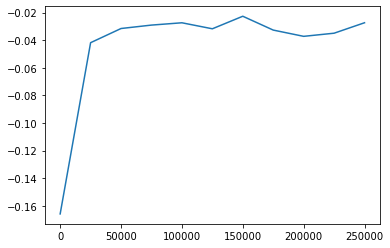

In [22]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 250001, 25000)), avg_reward_hist)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли
получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила
были упрощёнными, а на самом деле у игрока есть ещё и другие возможности.
Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением
ставки. Итак, у игрока появляется дополнительное действие:
* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 2.1 Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [23]:
from gym.envs.toy_text import BlackjackEnv

In [24]:
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


class DoubleBlackjackEnv(BlackjackEnv):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def draw_card(self, np_random):
        return int(np_random.choice(deck))

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add a card to players hand and finish game, reward will be doubled
            _, reward, done, _ = self.step(action=1) # hit
            if not done:
                _, reward, done, _ = self.step(action=0) # stick
            reward *= 2

        elif action == 1: # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0

        else:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(self.score(self.player), self.score(self.dealer))
            if self.sab and self.is_natural(self.player) and not self.is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and self.is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

### 2.2 Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [25]:
env = DoubleBlackjackEnv(natural=True)

In [26]:
best_alpha, best_epsilon, best_gamma = tuning_params(
    env=env,
    alpha_values=np.arange(0.002, 0.020, 0.002),
    epsilon_values=np.arange(0.05, 0.75, 0.1),
    gamma_values=np.arange(0.05, 0.45, 0.15),
    train_epochs=100000,
    eval_epochs=100000
)

  1%|          | 920/100000 [00:00<00:10, 9196.70it/s]

-0.051295
Best reward: -0.0513.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.05.


  1%|          | 974/100000 [00:00<00:10, 9736.41it/s]

-0.10338


  1%|          | 987/100000 [00:00<00:10, 9855.84it/s]

-0.11998


  2%|▏         | 1823/100000 [00:00<00:10, 9268.21it/s]

-0.05293


  1%|          | 929/100000 [00:00<00:10, 9285.76it/s]

-0.046015
Best reward: -0.0460.
alpha = 0.0020, epsilon = 0.1500, gamma = 0.20.


  1%|          | 927/100000 [00:00<00:10, 9266.89it/s]

-0.05531


  1%|          | 996/100000 [00:00<00:09, 9949.31it/s]

-0.03782
Best reward: -0.0378.
alpha = 0.0020, epsilon = 0.2500, gamma = 0.05.


  1%|          | 1095/100000 [00:00<00:09, 10944.24it/s]

-0.04225


  1%|          | 956/100000 [00:00<00:10, 9554.36it/s]

-0.08134


  1%|          | 998/100000 [00:00<00:09, 9970.43it/s]

-0.05257


  1%|          | 1032/100000 [00:00<00:09, 10311.45it/s]

-0.050395


  1%|          | 944/100000 [00:00<00:10, 9433.22it/s]

-0.06115


  1%|          | 999/100000 [00:00<00:09, 9988.39it/s]

-0.04032


  1%|          | 946/100000 [00:00<00:10, 9454.13it/s]

-0.04238


  1%|          | 960/100000 [00:00<00:10, 9590.93it/s]

-0.030075
Best reward: -0.0301.
alpha = 0.0020, epsilon = 0.4500, gamma = 0.35.


  1%|          | 979/100000 [00:00<00:10, 9778.91it/s]

-0.03702


  1%|          | 1003/100000 [00:00<00:09, 10024.01it/s]

-0.04848


  2%|▏         | 1872/100000 [00:00<00:10, 9355.00it/s]

-0.04198


  1%|          | 982/100000 [00:00<00:10, 9815.17it/s]

-0.030135


  1%|          | 1034/100000 [00:00<00:09, 10330.72it/s]

-0.023735
Best reward: -0.0237.
alpha = 0.0020, epsilon = 0.6500, gamma = 0.20.


  1%|          | 1004/100000 [00:00<00:09, 10037.83it/s]

-0.03353


  1%|          | 1045/100000 [00:00<00:09, 10434.64it/s]

-0.054735


  1%|          | 981/100000 [00:00<00:10, 9808.54it/s]

-0.04935


  1%|          | 1025/100000 [00:00<00:09, 10246.88it/s]

-0.05087


  1%|          | 1036/100000 [00:00<00:09, 10357.76it/s]

-0.054225


  1%|          | 1041/100000 [00:00<00:09, 10406.96it/s]

-0.053305


  1%|          | 1037/100000 [00:00<00:09, 10367.64it/s]

-0.07012


  1%|          | 1034/100000 [00:00<00:09, 10332.67it/s]

-0.0317


  1%|          | 1023/100000 [00:00<00:09, 10218.97it/s]

-0.04314


  1%|          | 1004/100000 [00:00<00:09, 10034.29it/s]

-0.04902


  1%|          | 962/100000 [00:00<00:10, 9615.91it/s]

-0.031695


  1%|          | 1010/100000 [00:00<00:09, 10092.43it/s]

-0.039535


  1%|          | 962/100000 [00:00<00:10, 9616.04it/s]

-0.054545


  1%|          | 977/100000 [00:00<00:10, 9768.50it/s]

-0.027475


  2%|▏         | 1928/100000 [00:00<00:10, 9670.42it/s]

-0.03719


  1%|          | 949/100000 [00:00<00:10, 9487.36it/s]

-0.030205


  2%|▏         | 2069/100000 [00:00<00:09, 10359.65it/s]

-0.0317


  1%|          | 879/100000 [00:00<00:11, 8787.05it/s]

-0.04024


  1%|          | 984/100000 [00:00<00:10, 9838.23it/s]

-0.042135


  1%|          | 991/100000 [00:00<00:09, 9905.10it/s]

-0.01903
Best reward: -0.0190.
alpha = 0.0040, epsilon = 0.6500, gamma = 0.05.


  2%|▏         | 1969/100000 [00:00<00:09, 9843.64it/s]

-0.022775


  1%|          | 1033/100000 [00:00<00:09, 10327.25it/s]

-0.022465


  1%|          | 1014/100000 [00:00<00:09, 10131.80it/s]

-0.034385


  1%|          | 949/100000 [00:00<00:10, 9485.06it/s]

-0.04185


  1%|          | 1028/100000 [00:00<00:09, 10278.93it/s]

-0.0635


  1%|          | 1019/100000 [00:00<00:09, 10180.30it/s]

-0.01896
Best reward: -0.0190.
alpha = 0.0060, epsilon = 0.1500, gamma = 0.05.


  1%|          | 1037/100000 [00:00<00:09, 10366.60it/s]

-0.035535


  1%|          | 1026/100000 [00:00<00:09, 10254.83it/s]

-0.055685


  1%|          | 1035/100000 [00:00<00:09, 10342.39it/s]

-0.028985


  1%|          | 973/100000 [00:00<00:10, 9725.74it/s]

-0.02635


  1%|          | 981/100000 [00:00<00:10, 9802.27it/s]

-0.0459


  1%|          | 1007/100000 [00:00<00:09, 10060.77it/s]

-0.032175


  1%|          | 996/100000 [00:00<00:09, 9956.16it/s]

-0.0316


  1%|          | 1017/100000 [00:00<00:09, 10163.44it/s]

-0.040115


  1%|          | 951/100000 [00:00<00:10, 9506.20it/s]

-0.02049


  1%|          | 1018/100000 [00:00<00:09, 10174.21it/s]

-0.02673


  1%|          | 1002/100000 [00:00<00:09, 10008.44it/s]

-0.038975


  1%|          | 986/100000 [00:00<00:10, 9859.28it/s]

-0.02738


  1%|          | 1012/100000 [00:00<00:09, 10112.42it/s]

-0.01831
Best reward: -0.0183.
alpha = 0.0060, epsilon = 0.5500, gamma = 0.20.


  1%|          | 979/100000 [00:00<00:10, 9780.03it/s]

-0.02583


  1%|          | 940/100000 [00:00<00:10, 9391.93it/s]

-0.03013


  1%|          | 986/100000 [00:00<00:10, 9854.49it/s]

-0.03045


  1%|          | 1035/100000 [00:00<00:09, 10346.68it/s]

-0.03222


  1%|          | 1024/100000 [00:00<00:09, 10233.76it/s]

-0.024155


  1%|          | 1009/100000 [00:00<00:09, 10087.12it/s]

-0.03948


  1%|          | 977/100000 [00:00<00:10, 9763.26it/s]

-0.052055


  1%|          | 974/100000 [00:00<00:10, 9737.43it/s]

-0.025745


  1%|          | 1034/100000 [00:00<00:09, 10338.31it/s]

-0.043165


  1%|          | 1019/100000 [00:00<00:09, 10187.31it/s]

-0.05209


  2%|▏         | 1967/100000 [00:00<00:09, 9844.42it/s]

-0.028995


  1%|          | 1012/100000 [00:00<00:09, 10115.86it/s]

-0.03126


  1%|          | 997/100000 [00:00<00:09, 9966.68it/s]

-0.05478


  1%|          | 999/100000 [00:00<00:09, 9983.15it/s]

-0.019605


  1%|          | 1054/100000 [00:00<00:09, 10531.45it/s]

-0.023765


  1%|          | 1052/100000 [00:00<00:09, 10513.42it/s]

-0.030585


  1%|          | 1042/100000 [00:00<00:09, 10417.65it/s]

-0.01423
Best reward: -0.0142.
alpha = 0.0080, epsilon = 0.4500, gamma = 0.05.


  2%|▏         | 2072/100000 [00:00<00:09, 10364.15it/s]

-0.02717


  1%|          | 1055/100000 [00:00<00:09, 10548.83it/s]

-0.027245


  1%|          | 1046/100000 [00:00<00:09, 10458.64it/s]

-0.03052


  1%|          | 969/100000 [00:00<00:10, 9685.53it/s]

-0.027975


  1%|          | 1048/100000 [00:00<00:09, 10479.01it/s]

-0.031445


  1%|          | 1026/100000 [00:00<00:09, 10254.22it/s]

-0.014835


  1%|          | 1050/100000 [00:00<00:09, 10496.18it/s]

-0.02121


  1%|          | 1067/100000 [00:00<00:09, 10661.98it/s]

-0.019405


  1%|          | 1074/100000 [00:00<00:09, 10735.94it/s]

-0.03233


  1%|          | 1095/100000 [00:00<00:09, 10940.78it/s]

-0.044955


  1%|          | 1067/100000 [00:00<00:09, 10663.68it/s]

-0.05226


  1%|          | 1077/100000 [00:00<00:09, 10763.08it/s]

-0.020415


  1%|          | 1070/100000 [00:00<00:09, 10695.32it/s]

-0.039305


  1%|          | 1077/100000 [00:00<00:09, 10765.62it/s]

-0.045955


  1%|          | 1086/100000 [00:00<00:09, 10859.10it/s]

-0.03471


  1%|          | 1055/100000 [00:00<00:09, 10547.02it/s]

-0.016335


  1%|          | 1025/100000 [00:00<00:09, 10248.18it/s]

-0.04856


  1%|          | 1047/100000 [00:00<00:09, 10468.21it/s]

-0.02278


  1%|          | 1046/100000 [00:00<00:09, 10455.42it/s]

-0.019715


  1%|          | 1068/100000 [00:00<00:09, 10674.84it/s]

-0.0381


  1%|          | 1043/100000 [00:00<00:09, 10424.39it/s]

-0.03528


  1%|          | 1042/100000 [00:00<00:09, 10419.14it/s]

-0.02786


  1%|          | 1049/100000 [00:00<00:09, 10482.94it/s]

-0.035265


  1%|          | 1066/100000 [00:00<00:09, 10656.17it/s]

-0.018095


  2%|▏         | 2070/100000 [00:00<00:09, 10328.40it/s]

-0.032045


  1%|          | 1040/100000 [00:00<00:09, 10391.44it/s]

-0.020805


  1%|          | 1016/100000 [00:00<00:09, 10158.97it/s]

-0.02044


  1%|          | 990/100000 [00:00<00:10, 9893.99it/s]

-0.03164


  1%|          | 1069/100000 [00:00<00:09, 10681.81it/s]

-0.03236


  1%|          | 1052/100000 [00:00<00:09, 10514.09it/s]

-0.02461


  1%|          | 1099/100000 [00:00<00:09, 10984.35it/s]

-0.024685


  1%|          | 1065/100000 [00:00<00:09, 10645.62it/s]

-0.039495


  1%|          | 1077/100000 [00:00<00:09, 10760.57it/s]

-0.014185
Best reward: -0.0142.
alpha = 0.0120, epsilon = 0.1500, gamma = 0.05.


  1%|          | 1068/100000 [00:00<00:09, 10670.65it/s]

-0.031205


  1%|          | 1060/100000 [00:00<00:09, 10591.55it/s]

-0.0386


  1%|          | 1047/100000 [00:00<00:09, 10460.53it/s]

-0.0216


  1%|          | 1077/100000 [00:00<00:09, 10762.88it/s]

-0.028685


  1%|          | 1079/100000 [00:00<00:09, 10782.02it/s]

-0.02546


  1%|          | 1065/100000 [00:00<00:09, 10639.71it/s]

-0.02132


  1%|          | 1061/100000 [00:00<00:09, 10607.43it/s]

-0.02621


  1%|          | 1042/100000 [00:00<00:09, 10411.89it/s]

-0.033905


  1%|          | 1056/100000 [00:00<00:09, 10559.36it/s]

-0.02213


  1%|          | 1049/100000 [00:00<00:09, 10484.01it/s]

-0.013745
Best reward: -0.0137.
alpha = 0.0120, epsilon = 0.4500, gamma = 0.20.


  1%|          | 1017/100000 [00:00<00:09, 10164.34it/s]

-0.03933


  1%|          | 1030/100000 [00:00<00:09, 10298.71it/s]

-0.02193


  1%|          | 1054/100000 [00:00<00:09, 10538.00it/s]

-0.021845


  1%|          | 1024/100000 [00:00<00:09, 10228.91it/s]

-0.022645


  1%|          | 1046/100000 [00:00<00:09, 10458.29it/s]

-0.02308


  1%|          | 1037/100000 [00:00<00:09, 10356.18it/s]

-0.025395


  1%|          | 1080/100000 [00:00<00:09, 10795.87it/s]

-0.02942


  1%|          | 1039/100000 [00:00<00:09, 10387.16it/s]

-0.034225


  1%|          | 1063/100000 [00:00<00:09, 10626.92it/s]

-0.038695


  1%|          | 1055/100000 [00:00<00:09, 10546.51it/s]

-0.03941


  1%|          | 1061/100000 [00:00<00:09, 10606.75it/s]

-0.03562


  1%|          | 1077/100000 [00:00<00:09, 10763.57it/s]

-0.032065


  1%|          | 1057/100000 [00:00<00:09, 10564.29it/s]

-0.046145


  1%|          | 1035/100000 [00:00<00:09, 10348.58it/s]

-0.015455


  1%|          | 1049/100000 [00:00<00:09, 10485.04it/s]

-0.0277


  1%|          | 1068/100000 [00:00<00:09, 10673.32it/s]

-0.043445


  1%|          | 1000/100000 [00:00<00:09, 9995.89it/s]

-0.017945


  1%|          | 1043/100000 [00:00<00:09, 10419.15it/s]

-0.027545


  1%|          | 1051/100000 [00:00<00:09, 10506.40it/s]

-0.030945


  1%|          | 1042/100000 [00:00<00:09, 10416.73it/s]

-0.023985


  1%|          | 1033/100000 [00:00<00:09, 10321.84it/s]

-0.02317


  1%|          | 1031/100000 [00:00<00:09, 10300.06it/s]

-0.037445


  1%|          | 1053/100000 [00:00<00:09, 10524.87it/s]

-0.016945


  1%|          | 1035/100000 [00:00<00:09, 10342.22it/s]

-0.023965


  1%|          | 1050/100000 [00:00<00:09, 10499.51it/s]

-0.020545


  1%|          | 1045/100000 [00:00<00:09, 10443.74it/s]

-0.02146


  1%|          | 1042/100000 [00:00<00:09, 10417.68it/s]

-0.019485


  1%|          | 1048/100000 [00:00<00:09, 10476.81it/s]

-0.03319


  1%|          | 1080/100000 [00:00<00:09, 10791.11it/s]

-0.030805


  1%|          | 1086/100000 [00:00<00:09, 10852.58it/s]

-0.03693


  1%|          | 1057/100000 [00:00<00:09, 10560.19it/s]

-0.04929


  2%|▏         | 2144/100000 [00:00<00:09, 10702.73it/s]

-0.02023


  1%|          | 1076/100000 [00:00<00:09, 10754.42it/s]

-0.028375


  1%|          | 1074/100000 [00:00<00:09, 10736.50it/s]

-0.04673


  2%|▏         | 2081/100000 [00:00<00:09, 10401.63it/s]

-0.017925


  1%|          | 1038/100000 [00:00<00:09, 10373.48it/s]

-0.021225


  1%|          | 1080/100000 [00:00<00:09, 10794.76it/s]

-0.03624


  1%|          | 1047/100000 [00:00<00:09, 10468.39it/s]

-0.01354
Best reward: -0.0135.
alpha = 0.0160, epsilon = 0.3500, gamma = 0.05.


  2%|▏         | 2044/100000 [00:00<00:09, 10217.41it/s]

-0.0292


  1%|          | 1040/100000 [00:00<00:09, 10390.92it/s]

-0.03143


  1%|          | 1056/100000 [00:00<00:09, 10553.17it/s]

-0.019675


  1%|          | 1058/100000 [00:00<00:09, 10575.60it/s]

-0.029985


  2%|▏         | 2052/100000 [00:00<00:09, 10256.42it/s]

-0.043315


  1%|          | 997/100000 [00:00<00:09, 9964.69it/s]

-0.022225


  1%|          | 1059/100000 [00:00<00:09, 10587.41it/s]

-0.02882


  1%|          | 1036/100000 [00:00<00:09, 10350.73it/s]

-0.038005


  1%|          | 1024/100000 [00:00<00:09, 10234.13it/s]

-0.02222


  1%|          | 1026/100000 [00:00<00:09, 10255.66it/s]

-0.020885


  1%|          | 1054/100000 [00:00<00:09, 10526.76it/s]

-0.030275


  1%|          | 1083/100000 [00:00<00:09, 10827.87it/s]

-0.028585


  1%|          | 1088/100000 [00:00<00:09, 10870.27it/s]

-0.02537


  1%|          | 1079/100000 [00:00<00:09, 10782.86it/s]

-0.04833


  1%|          | 1059/100000 [00:00<00:09, 10585.62it/s]

-0.030125


  1%|          | 998/100000 [00:00<00:09, 9978.56it/s]

-0.02588


  1%|          | 1050/100000 [00:00<00:09, 10491.76it/s]

-0.03923


  1%|          | 1076/100000 [00:00<00:09, 10749.43it/s]

-0.0206


  1%|          | 1050/100000 [00:00<00:09, 10498.38it/s]

-0.01455


  1%|          | 1062/100000 [00:00<00:09, 10617.35it/s]

-0.03449


  1%|          | 1047/100000 [00:00<00:09, 10457.79it/s]

-0.018565


  1%|          | 1056/100000 [00:00<00:09, 10551.00it/s]

-0.020245


  1%|          | 1013/100000 [00:00<00:09, 10125.18it/s]

-0.04315


  1%|          | 1061/100000 [00:00<00:09, 10602.07it/s]

-0.02353


  1%|          | 1045/100000 [00:00<00:09, 10442.86it/s]

-0.024845


  1%|          | 1057/100000 [00:00<00:09, 10561.05it/s]

-0.0305


  1%|          | 1049/100000 [00:00<00:09, 10486.78it/s]

-0.027375


  1%|          | 1058/100000 [00:00<00:09, 10570.06it/s]

-0.035


  1%|          | 1048/100000 [00:00<00:09, 10475.94it/s]

-0.040495


  1%|          | 1031/100000 [00:00<00:09, 10303.94it/s]

-0.028655


  1%|          | 1022/100000 [00:00<00:09, 10213.17it/s]

-0.02078


100%|██████████| 100000/100000 [00:07<00:00, 13532.38it/s]

-0.029945


In [27]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=250001,
    track_history=True
)

100%|██████████| 250001/250001 [00:24<00:00, 10028.73it/s]


In [28]:
avg_reward(env, pi, epochs=200000)

100%|██████████| 200000/200000 [00:14<00:00, 13739.27it/s]


-0.0180575

100%|██████████| 200000/200000 [00:14<00:00, 13989.61it/s]


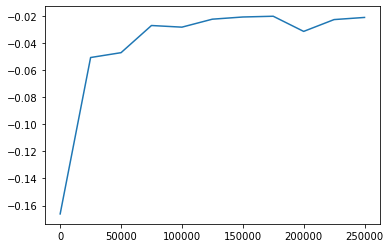

In [29]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 250001, 25000)), avg_reward_hist)

## Часть третья, в главной роли — Дастин Хоффман  
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 3.1 Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. 

Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке]( https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).

In [30]:
# https://ru.wikipedia.org/wiki/Блэкджэк#Подсчёт_карт
# "Половинки" с удвоенным счетом
counting_score = {
    1: -2,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 2,
    7: 1,
    8: 0,
    9: -1,
    10: -2,
}

In [31]:
class CountingBlackjackEnv(DoubleBlackjackEnv):

    def __init__(self, natural=False, sab=False, num_decks=4, reshuffle_limit=15):
        
        self.decks = deck * num_decks
        self.counting_max = 11 * num_decks
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32),
                spaces.Discrete(11),
                spaces.Discrete(2),
                spaces.Box(
                    -self.counting_max,
                    self.counting_max, shape=(1, 1)
                )
            )
        )

        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        # Active decks for card drawing
        self.num_decks = num_decks

        # Minimal cards in deck to start reshuffling
        self.reshuffle_limit = reshuffle_limit

        self.reshuffle_decks()

    def draw_card(self, np_random):
        card = int(self.decks.pop(np_random.choice(len(self.decks))))
        self.count += counting_score[card]
        return card

    def reshuffle_decks(self):
        # Stored decks
        self.decks = deck * self.num_decks
        # Stored count
        self.count = 0

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0],
                self.usable_ace(self.player), self.count)

    def reset(self):
        if len(self.decks) < self.reshuffle_limit:
            self.reshuffle_decks()
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

### 3.2 Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [32]:
env = CountingBlackjackEnv(natural=True)

In [33]:
# в дискретном пространстве состояний можно записать стратегию 
# как словарь состоягие -> действие

states_list = list(
    itertools.product(
        range(2, 33), # the players current sum, 32 для Q learning !!!!!!!!
        range(1, 11), # the dealer's one showing card (1-10 where 1 is ace),
        (True, False), # the player holds a usable ace
        range(-env.counting_max, env.counting_max) # counting cards
    )
)

states_to_idx = {state: i for i, state in enumerate(states_list)}

In [34]:
best_alpha, best_epsilon, best_gamma = tuning_params(
    env=env,
    alpha_values=np.arange(0.002, 0.020, 0.002),
    epsilon_values=np.arange(0.05, 0.75, 0.1),
    gamma_values=np.arange(0.05, 0.45, 0.15),
    train_epochs=100000,
    eval_epochs=100000
)

  0%|          | 429/100000 [00:00<00:23, 4280.70it/s]

-0.12844
Best reward: -0.1284.
alpha = 0.0020, epsilon = 0.0500, gamma = 0.05.


  0%|          | 408/100000 [00:00<00:24, 4078.35it/s]

-0.131015


  0%|          | 432/100000 [00:00<00:23, 4317.32it/s]

-0.132645


  0%|          | 414/100000 [00:00<00:24, 4137.58it/s]

-0.115585
Best reward: -0.1156.
alpha = 0.0020, epsilon = 0.1500, gamma = 0.05.


  0%|          | 417/100000 [00:00<00:23, 4167.04it/s]

-0.12896


  0%|          | 421/100000 [00:00<00:23, 4204.10it/s]

-0.11927


  0%|          | 416/100000 [00:00<00:23, 4151.90it/s]

-0.114825
Best reward: -0.1148.
alpha = 0.0020, epsilon = 0.2500, gamma = 0.05.


  0%|          | 421/100000 [00:00<00:23, 4204.29it/s]

-0.107565
Best reward: -0.1076.
alpha = 0.0020, epsilon = 0.2500, gamma = 0.20.


  0%|          | 429/100000 [00:00<00:23, 4279.66it/s]

-0.111455


  0%|          | 425/100000 [00:00<00:23, 4248.02it/s]

-0.11219


  0%|          | 423/100000 [00:00<00:23, 4224.98it/s]

-0.10282
Best reward: -0.1028.
alpha = 0.0020, epsilon = 0.3500, gamma = 0.20.


  0%|          | 414/100000 [00:00<00:24, 4132.28it/s]

-0.105985


  0%|          | 427/100000 [00:00<00:23, 4267.40it/s]

-0.09184
Best reward: -0.0918.
alpha = 0.0020, epsilon = 0.4500, gamma = 0.05.


  0%|          | 400/100000 [00:00<00:24, 3992.38it/s]

-0.098725


  0%|          | 420/100000 [00:00<00:23, 4199.04it/s]

-0.09721


  0%|          | 423/100000 [00:00<00:23, 4229.56it/s]

-0.09833


  0%|          | 405/100000 [00:00<00:24, 4043.43it/s]

-0.092975


  0%|          | 422/100000 [00:00<00:23, 4219.80it/s]

-0.10041


  0%|          | 408/100000 [00:00<00:24, 4075.85it/s]

-0.08891
Best reward: -0.0889.
alpha = 0.0020, epsilon = 0.6500, gamma = 0.05.


  0%|          | 416/100000 [00:00<00:23, 4158.16it/s]

-0.089885


  0%|          | 433/100000 [00:00<00:23, 4320.76it/s]

-0.09587


  0%|          | 421/100000 [00:00<00:23, 4204.70it/s]

-0.11437


  0%|          | 433/100000 [00:00<00:23, 4328.35it/s]

-0.131195


  0%|          | 420/100000 [00:00<00:23, 4199.26it/s]

-0.131605


  1%|          | 842/100000 [00:00<00:23, 4206.76it/s]

-0.117045


  0%|          | 426/100000 [00:00<00:23, 4257.78it/s]

-0.116745


  0%|          | 421/100000 [00:00<00:23, 4207.16it/s]

-0.11435


  0%|          | 431/100000 [00:00<00:23, 4306.28it/s]

-0.11307


  0%|          | 415/100000 [00:00<00:24, 4145.46it/s]

-0.10789


  0%|          | 426/100000 [00:00<00:23, 4256.87it/s]

-0.111745


  0%|          | 429/100000 [00:00<00:23, 4281.17it/s]

-0.113525


  0%|          | 417/100000 [00:00<00:23, 4162.48it/s]

-0.10233


  0%|          | 419/100000 [00:00<00:23, 4180.66it/s]

-0.111725


  0%|          | 407/100000 [00:00<00:24, 4069.70it/s]

-0.097225


  0%|          | 422/100000 [00:00<00:23, 4210.11it/s]

-0.09366


  0%|          | 417/100000 [00:00<00:23, 4162.82it/s]

-0.106515


  0%|          | 412/100000 [00:00<00:24, 4110.59it/s]

-0.085385
Best reward: -0.0854.
alpha = 0.0040, epsilon = 0.5500, gamma = 0.05.


  0%|          | 426/100000 [00:00<00:23, 4250.85it/s]

-0.0874


  0%|          | 352/100000 [00:00<00:28, 3512.99it/s]

-0.09011


  0%|          | 389/100000 [00:00<00:25, 3880.67it/s]

-0.091255


  0%|          | 395/100000 [00:00<00:25, 3948.53it/s]

-0.0959


  0%|          | 408/100000 [00:00<00:24, 4070.29it/s]

-0.09961


  0%|          | 411/100000 [00:00<00:24, 4103.20it/s]

-0.122115


  0%|          | 382/100000 [00:00<00:26, 3814.87it/s]

-0.12978


  0%|          | 401/100000 [00:00<00:24, 4005.39it/s]

-0.12488


  0%|          | 410/100000 [00:00<00:24, 4091.29it/s]

-0.11682


  0%|          | 393/100000 [00:00<00:25, 3927.36it/s]

-0.112605


  0%|          | 389/100000 [00:00<00:25, 3881.52it/s]

-0.128195


  1%|          | 808/100000 [00:00<00:24, 4037.87it/s]

-0.099465


  0%|          | 407/100000 [00:00<00:24, 4068.59it/s]

-0.10828


  0%|          | 401/100000 [00:00<00:24, 4002.97it/s]

-0.112925


  0%|          | 408/100000 [00:00<00:24, 4072.28it/s]

-0.103405


  0%|          | 400/100000 [00:00<00:24, 3995.13it/s]

-0.104735


  0%|          | 427/100000 [00:00<00:23, 4267.52it/s]

-0.09687


  0%|          | 417/100000 [00:00<00:23, 4167.01it/s]

-0.09839


  0%|          | 411/100000 [00:00<00:24, 4108.40it/s]

-0.093325


  0%|          | 421/100000 [00:00<00:23, 4203.98it/s]

-0.113335


  0%|          | 425/100000 [00:00<00:23, 4242.44it/s]

-0.086795


  0%|          | 424/100000 [00:00<00:23, 4233.48it/s]

-0.09994


  0%|          | 416/100000 [00:00<00:23, 4154.08it/s]

-0.09748


  0%|          | 422/100000 [00:00<00:23, 4213.03it/s]

-0.08729


  0%|          | 422/100000 [00:00<00:23, 4214.61it/s]

-0.09709


  0%|          | 432/100000 [00:00<00:23, 4319.30it/s]

-0.093165


  0%|          | 433/100000 [00:00<00:23, 4324.07it/s]

-0.125555


  0%|          | 421/100000 [00:00<00:23, 4203.61it/s]

-0.12856


  0%|          | 434/100000 [00:00<00:22, 4331.39it/s]

-0.12654


  0%|          | 427/100000 [00:00<00:23, 4265.52it/s]

-0.112615


  0%|          | 421/100000 [00:00<00:23, 4205.65it/s]

-0.115675


  0%|          | 424/100000 [00:00<00:23, 4236.92it/s]

-0.1229


  0%|          | 427/100000 [00:00<00:23, 4264.76it/s]

-0.10248


  0%|          | 422/100000 [00:00<00:23, 4210.82it/s]

-0.105225


  0%|          | 423/100000 [00:00<00:23, 4221.13it/s]

-0.101435


  0%|          | 412/100000 [00:00<00:24, 4114.92it/s]

-0.09881


  0%|          | 431/100000 [00:00<00:23, 4301.78it/s]

-0.103405


  0%|          | 408/100000 [00:00<00:24, 4070.87it/s]

-0.103965


  0%|          | 425/100000 [00:00<00:23, 4248.53it/s]

-0.09982


  0%|          | 417/100000 [00:00<00:23, 4168.52it/s]

-0.0891


  0%|          | 422/100000 [00:00<00:23, 4219.35it/s]

-0.090105


  0%|          | 410/100000 [00:00<00:24, 4089.85it/s]

-0.092005


  0%|          | 421/100000 [00:00<00:23, 4209.73it/s]

-0.101125


  0%|          | 419/100000 [00:00<00:23, 4187.85it/s]

-0.09419


  0%|          | 422/100000 [00:00<00:23, 4211.53it/s]

-0.08501
Best reward: -0.0850.
alpha = 0.0080, epsilon = 0.6500, gamma = 0.05.


  0%|          | 412/100000 [00:00<00:24, 4115.87it/s]

-0.09831


  0%|          | 434/100000 [00:00<00:22, 4336.97it/s]

-0.089035


  0%|          | 437/100000 [00:00<00:22, 4361.99it/s]

-0.124545


  0%|          | 434/100000 [00:00<00:22, 4334.88it/s]

-0.115995


  0%|          | 421/100000 [00:00<00:23, 4202.12it/s]

-0.11954


  0%|          | 432/100000 [00:00<00:23, 4317.91it/s]

-0.123515


  0%|          | 431/100000 [00:00<00:23, 4306.23it/s]

-0.105735


  0%|          | 411/100000 [00:00<00:24, 4100.14it/s]

-0.116275


  0%|          | 425/100000 [00:00<00:23, 4248.36it/s]

-0.106735


  1%|          | 858/100000 [00:00<00:23, 4279.46it/s]

-0.105655


  0%|          | 411/100000 [00:00<00:24, 4109.15it/s]

-0.096895


  0%|          | 415/100000 [00:00<00:24, 4139.71it/s]

-0.09922


  0%|          | 424/100000 [00:00<00:23, 4235.89it/s]

-0.087785


  0%|          | 416/100000 [00:00<00:23, 4151.44it/s]

-0.09997


  0%|          | 421/100000 [00:00<00:23, 4205.23it/s]

-0.09165


  0%|          | 425/100000 [00:00<00:23, 4245.21it/s]

-0.095305


  0%|          | 428/100000 [00:00<00:23, 4278.14it/s]

-0.087105


  0%|          | 425/100000 [00:00<00:23, 4242.68it/s]

-0.089165


  0%|          | 388/100000 [00:00<00:25, 3875.72it/s]

-0.084305
Best reward: -0.0843.
alpha = 0.0100, epsilon = 0.5500, gamma = 0.20.


  0%|          | 418/100000 [00:00<00:23, 4174.31it/s]

-0.090815


  0%|          | 426/100000 [00:00<00:23, 4254.86it/s]

-0.09612


  0%|          | 421/100000 [00:00<00:23, 4207.12it/s]

-0.082405
Best reward: -0.0824.
alpha = 0.0100, epsilon = 0.6500, gamma = 0.20.


  0%|          | 437/100000 [00:00<00:22, 4362.16it/s]

-0.090715


  0%|          | 437/100000 [00:00<00:22, 4369.00it/s]

-0.12517


  0%|          | 435/100000 [00:00<00:22, 4342.40it/s]

-0.11996


  0%|          | 416/100000 [00:00<00:23, 4155.76it/s]

-0.115055


  0%|          | 431/100000 [00:00<00:23, 4305.06it/s]

-0.12104


  0%|          | 434/100000 [00:00<00:22, 4331.98it/s]

-0.102415


  0%|          | 417/100000 [00:00<00:23, 4162.08it/s]

-0.118775


  0%|          | 428/100000 [00:00<00:23, 4270.11it/s]

-0.10354


  0%|          | 348/100000 [00:00<00:28, 3471.68it/s]

-0.11286


  0%|          | 423/100000 [00:00<00:23, 4224.89it/s]

-0.107555


  0%|          | 428/100000 [00:00<00:23, 4273.14it/s]

-0.10069


  0%|          | 426/100000 [00:00<00:23, 4258.90it/s]

-0.098845


  0%|          | 426/100000 [00:00<00:23, 4255.07it/s]

-0.113085


  0%|          | 397/100000 [00:00<00:25, 3965.67it/s]

-0.085265


  0%|          | 427/100000 [00:00<00:23, 4265.94it/s]

-0.09476


  0%|          | 414/100000 [00:00<00:24, 4134.00it/s]

-0.10655


  0%|          | 404/100000 [00:00<00:24, 4039.75it/s]

-0.093955


  0%|          | 419/100000 [00:00<00:23, 4184.55it/s]

-0.09187


  0%|          | 421/100000 [00:00<00:23, 4203.64it/s]

-0.095915


  0%|          | 411/100000 [00:00<00:24, 4109.69it/s]

-0.083305


  0%|          | 420/100000 [00:00<00:23, 4194.25it/s]

-0.087565


  0%|          | 436/100000 [00:00<00:22, 4359.48it/s]

-0.087365


  0%|          | 434/100000 [00:00<00:22, 4337.88it/s]

-0.113285


  0%|          | 429/100000 [00:00<00:23, 4283.76it/s]

-0.105175


  0%|          | 437/100000 [00:00<00:22, 4367.80it/s]

-0.12604


  0%|          | 431/100000 [00:00<00:23, 4304.81it/s]

-0.101645


  0%|          | 429/100000 [00:00<00:23, 4272.77it/s]

-0.108825


  0%|          | 432/100000 [00:00<00:23, 4310.42it/s]

-0.108195


  0%|          | 430/100000 [00:00<00:23, 4289.83it/s]

-0.09438


  0%|          | 428/100000 [00:00<00:23, 4270.28it/s]

-0.108775


  0%|          | 426/100000 [00:00<00:23, 4249.95it/s]

-0.10335


  0%|          | 426/100000 [00:00<00:23, 4254.97it/s]

-0.103935


  0%|          | 428/100000 [00:00<00:23, 4276.26it/s]

-0.089325


  0%|          | 427/100000 [00:00<00:23, 4262.20it/s]

-0.103125


  0%|          | 420/100000 [00:00<00:23, 4193.69it/s]

-0.09469


  0%|          | 413/100000 [00:00<00:24, 4120.41it/s]

-0.08543


  0%|          | 423/100000 [00:00<00:23, 4221.64it/s]

-0.08649


  0%|          | 422/100000 [00:00<00:23, 4214.72it/s]

-0.090305


  0%|          | 400/100000 [00:00<00:24, 3997.68it/s]

-0.08229
Best reward: -0.0823.
alpha = 0.0140, epsilon = 0.5500, gamma = 0.20.


  0%|          | 417/100000 [00:00<00:23, 4169.83it/s]

-0.085465


  0%|          | 420/100000 [00:00<00:23, 4195.19it/s]

-0.08645


  0%|          | 420/100000 [00:00<00:23, 4190.29it/s]

-0.09026


  0%|          | 410/100000 [00:00<00:24, 4089.49it/s]

-0.092035


  0%|          | 429/100000 [00:00<00:23, 4288.09it/s]

-0.119445


  0%|          | 437/100000 [00:00<00:22, 4366.90it/s]

-0.11176


  0%|          | 431/100000 [00:00<00:23, 4309.03it/s]

-0.120535


  0%|          | 420/100000 [00:00<00:23, 4194.87it/s]

-0.10684


  0%|          | 431/100000 [00:00<00:23, 4309.50it/s]

-0.10772


  0%|          | 422/100000 [00:00<00:23, 4215.94it/s]

-0.103395


  0%|          | 420/100000 [00:00<00:23, 4190.06it/s]

-0.094285


  0%|          | 432/100000 [00:00<00:23, 4317.34it/s]

-0.102005


  0%|          | 425/100000 [00:00<00:23, 4249.85it/s]

-0.094535


  0%|          | 425/100000 [00:00<00:23, 4248.95it/s]

-0.088705


  0%|          | 429/100000 [00:00<00:23, 4285.15it/s]

-0.087585


  0%|          | 417/100000 [00:00<00:23, 4162.36it/s]

-0.100185


  0%|          | 424/100000 [00:00<00:23, 4233.09it/s]

-0.08892


  0%|          | 422/100000 [00:00<00:23, 4217.08it/s]

-0.089745


  0%|          | 419/100000 [00:00<00:23, 4183.07it/s]

-0.10297


  0%|          | 421/100000 [00:00<00:23, 4200.30it/s]

-0.09009


  0%|          | 414/100000 [00:00<00:24, 4134.39it/s]

-0.091285


  0%|          | 420/100000 [00:00<00:23, 4194.55it/s]

-0.099235


  0%|          | 423/100000 [00:00<00:23, 4224.48it/s]

-0.080475
Best reward: -0.0805.
alpha = 0.0160, epsilon = 0.6500, gamma = 0.05.


  0%|          | 407/100000 [00:00<00:24, 4061.93it/s]

-0.094375


  0%|          | 439/100000 [00:00<00:22, 4389.76it/s]

-0.086085


  0%|          | 438/100000 [00:00<00:22, 4376.65it/s]

-0.119605


  0%|          | 416/100000 [00:00<00:23, 4151.45it/s]

-0.121615


  0%|          | 430/100000 [00:00<00:23, 4291.32it/s]

-0.111955


  0%|          | 422/100000 [00:00<00:23, 4219.75it/s]

-0.099955


  0%|          | 409/100000 [00:00<00:24, 4083.46it/s]

-0.096765


  0%|          | 431/100000 [00:00<00:23, 4306.17it/s]

-0.10703


  0%|          | 419/100000 [00:00<00:23, 4184.90it/s]

-0.10205


  0%|          | 432/100000 [00:00<00:23, 4313.35it/s]

-0.109905


  0%|          | 425/100000 [00:00<00:23, 4248.22it/s]

-0.09502


  0%|          | 425/100000 [00:00<00:23, 4246.02it/s]

-0.09169


  0%|          | 423/100000 [00:00<00:23, 4226.08it/s]

-0.09793


  0%|          | 415/100000 [00:00<00:24, 4141.97it/s]

-0.09426


  0%|          | 419/100000 [00:00<00:23, 4183.46it/s]

-0.08799


  0%|          | 422/100000 [00:00<00:23, 4212.67it/s]

-0.090135


  0%|          | 423/100000 [00:00<00:23, 4223.28it/s]

-0.097025


  0%|          | 415/100000 [00:00<00:24, 4143.68it/s]

-0.09258


  0%|          | 420/100000 [00:00<00:23, 4194.85it/s]

-0.086475


  0%|          | 419/100000 [00:00<00:23, 4180.14it/s]

-0.088565


  0%|          | 415/100000 [00:00<00:24, 4148.89it/s]

-0.080505


  0%|          | 417/100000 [00:00<00:23, 4162.93it/s]

-0.085185


100%|██████████| 100000/100000 [00:06<00:00, 15911.49it/s]

-0.08273


In [35]:
pi, pi_hist = Q_learning(
    env, 
    alpha=best_alpha,
    epsilon=best_epsilon, 
    gamma=best_gamma, 
    epochs=1000001,
    track_history=True
)

100%|██████████| 1000001/1000001 [04:53<00:00, 3411.74it/s]


In [36]:
avg_reward(env, pi, epochs=200000)

100%|██████████| 200000/200000 [00:12<00:00, 15858.23it/s]


-0.0125675

100%|██████████| 200000/200000 [00:12<00:00, 15570.85it/s]


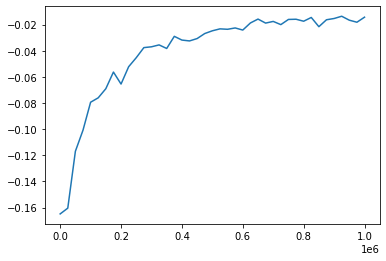

In [37]:
avg_reward_hist = [avg_reward(env, pi, epochs=200000) for pi in pi_hist]

plt.plot(list(range(0, 1000001, 25000)), avg_reward_hist)